In [2]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_json('tops_fashion.json')

In [4]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

In [5]:
data.head()

,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,None,B016I2TS4W,SHIRT,None,None,None,FNC7C,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Women's O Nec...,Minions Como Superheroes Ironman Long Sleeve R...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
1,None,B01N49AI08,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Izo Tunic,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
2,None,B01JDPCOHO,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Won Top,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
3,None,B01N19U5H5,SHIRT,None,None,None,Focal18,None,None,"[True, https://www.amazon.com/reviews/iframe?a...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,100% Brand New & Fashion<br> Quantity: 1 Piece...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
4,None,B004GSI2OS,SHIRT,$26.26,None,Onyx Black/ Stone,FeatherLite,None,Usually ships in 6-10 business days,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,,Featherlite Ladies' Long Sleeve Stain Resistan...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN


In [6]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [7]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() # prints the top rows in the table.

Number of data points :  183138 Number of features: 7


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


In [8]:
# We have total 72 unique type of product_type_names
print(data['product_type_name'].describe())

# 91.62% (167794/183138) of the products are shirts,

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [9]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [10]:
# find the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

In [11]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [12]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

In [13]:
print(data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [14]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

In [15]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

In [16]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [17]:
data.to_pickle('180k_apparel_data')

In [18]:
# consider products which have price information
# data['formatted_price'].isnull() => gives the information 
#about the dataframe row's which have null values price == None|Null
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [19]:
# consider products which have color information
# data['color'].isnull() => gives the information about the dataframe row's which have null values price == None|Null
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


In [20]:
data.to_pickle('28k_apparel_data')

In [21]:
# You can download all these 28k images using this code below.
# You do NOT need to run this code and hence it is commented.


'''
from PIL import Image
import requests
from io import BytesIO

for index, row in images.iterrows():
        url = row['large_image_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save('images/28k_images/'+row['asin']+'.jpeg')


'''

"\nfrom PIL import Image\nimport requests\nfrom io import BytesIO\n\nfor index, row in images.iterrows():\n        url = row['large_image_url']\n        response = requests.get(url)\n        img = Image.open(BytesIO(response.content))\n        img.save('images/28k_images/'+row['asin']+'.jpeg')\n\n\n"

In [23]:
# read data from pickle file from previous stage
data = pd.read_pickle('28k_apparel_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))
# we have 2325 products which have same title but different color


2325


In [24]:
# read data from pickle file from previous stage
data = pd.read_pickle('28k_apparel_data')

In [25]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
11,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,$11.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
21,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,$7.50


In [26]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [27]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


In [28]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [29]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [30]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [31]:
print('Number of data points : ', data.shape[0])

Number of data points :  17593


In [32]:
data.to_pickle('17k_apperal_data')

In [33]:
data = pd.read_pickle('17k_apperal_data')

In [34]:
# This code snippet takes significant amount of time.
# O(n^2) time.
# Takes about an hour to run on a decent computer.

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [39]:
# from whole previous products we will consider only 
# the products that are found in previous cell 
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [40]:
print('Number of data points after stage two of dedupe: ',data.shape[0])
# from 17k apperals we reduced to 16k apperals

Number of data points after stage two of dedupe:  16435


In [41]:
data.to_pickle('16k_apperal_data')
# Storing these products in a pickle file
# candidates who wants to download these files instead 
# of 180K they can download and use them from the Google Drive folder

In [42]:
data = pd.read_pickle('16k_apperal_data')

# NLTK download stop words. [RUN ONLY ONCE]
# goto Terminal (Linux/Mac) or Command-Prompt (Window) 
# In the temrinal, type these commands
# $python3
# $import nltk
# $nltk.download()

In [43]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'when', 's', 'through', "doesn't", 'how', 'ourselves', 'haven', 'over', "i've", 'hadn', 'was', 'at', 'from', 'these', 'all', 'while', 'again', 'between', 'doesn', 'few', 'because', 'below', 'his', 'very', 'we', "hadn't", 'out', 'so', 'won', 'against', 're', "i'm", 'or', 'their', 'are', 'with', 'were', "shouldn't", 'during', 'each', 'o', "should've", 'i', 'shouldn', 'who', "won't", 'up', 'and', 'above', 'she', 'will', 'your', "mightn't", 'nor', 'but', 'now', "she'd", "she'll", 'ours', 'wouldn', 'further', 'her', 'into', 'those', 'which', 'had', 'to', 'both', 'wasn', 'yourself', 'some', 'for', 'have', 'am', 'mightn', "we've", 'ma', 'other', "he'd", 'itself', "he's", "mustn't", 'then', 'where', "wouldn't", 'does', 'don', 'it', 'same', 'no', "he'll", 'needn', 'theirs', 'once', 'than', "needn't", "it's", 'our', 'they', 'aren', 'him', 'down', "we're", 'such', 'll', "they'd", 't', "you'll", 'y', 'me', 'in', 'my', 'having', "that'll", "couldn't", "she's", 'this', 'most', "

In [44]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

AttributeError: module 'time' has no attribute 'clock'

In [45]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel O Nec...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Fifth Degree Womens Gold Foil Graphic Tees Jun...,$6.95


In [46]:
data.to_pickle('16k_apperal_data_preprocessed')

In [47]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))


# We tried using stemming on our titles and it didnot work very well. 


argu
fish


In [48]:
data = pd.read_pickle('16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel O Nec...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Fifth Degree Womens Gold Foil Graphic Tees Jun...,$6.95


In [49]:
# Utility Functions which we will use through the rest of the project


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns 
# the a sparase matrix of dimensions #data_points * #words_in_corpus

# What is a sparse vector?


(16435, 11157)

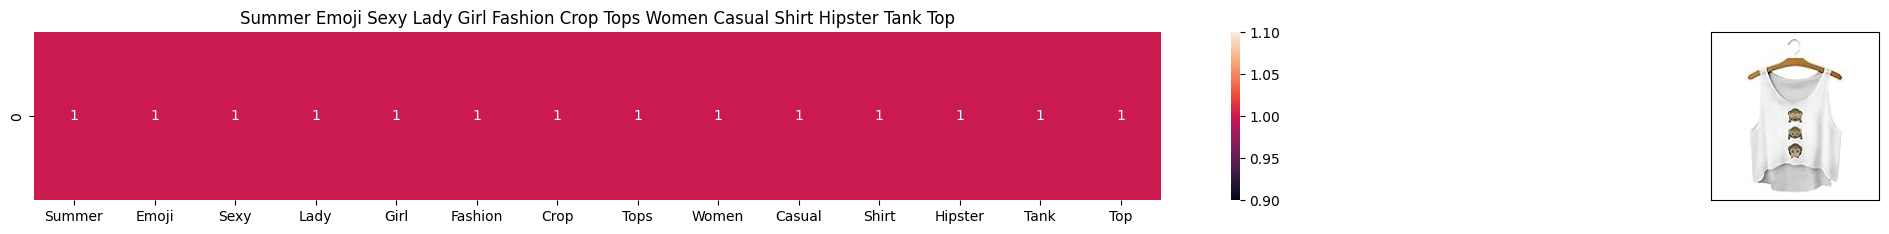

ASIN : B010V3BDII
Brand: Doxi Supermall
Title: Summer Emoji Sexy Lady Girl Fashion Crop Tops Women Casual Shirt Hipster Tank Top
Euclidean similarity with the query image : 0.0


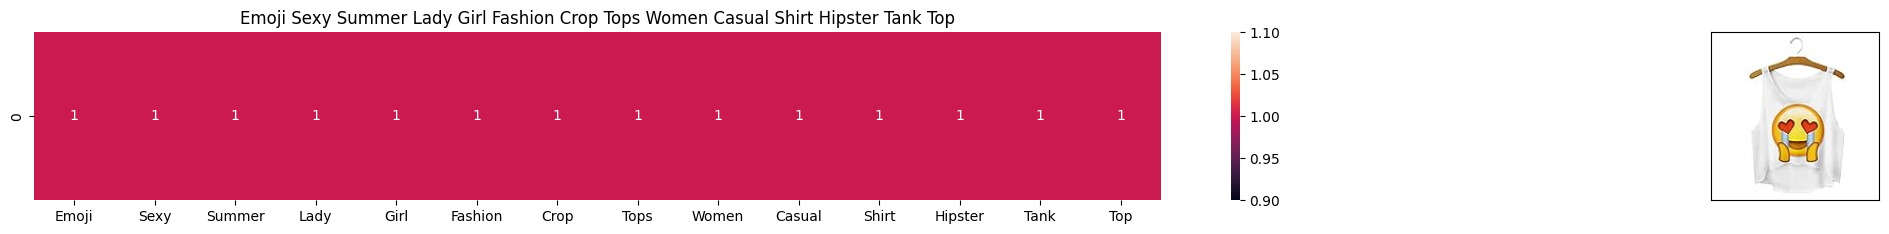

ASIN : B010V3BLWQ
Brand: Doxi Supermall
Title: Emoji Sexy Summer Lady Girl Fashion Crop Tops Women Casual Shirt Hipster Tank Top
Euclidean similarity with the query image : 0.0


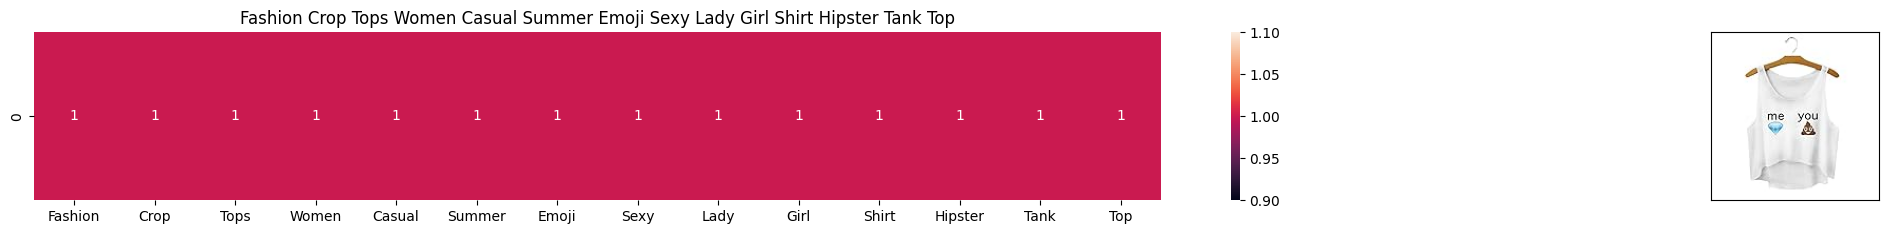

ASIN : B010V3B44G
Brand: Doxi Supermall
Title: Fashion Crop Tops Women Casual Summer Emoji Sexy Lady Girl Shirt Hipster Tank Top
Euclidean similarity with the query image : 0.0


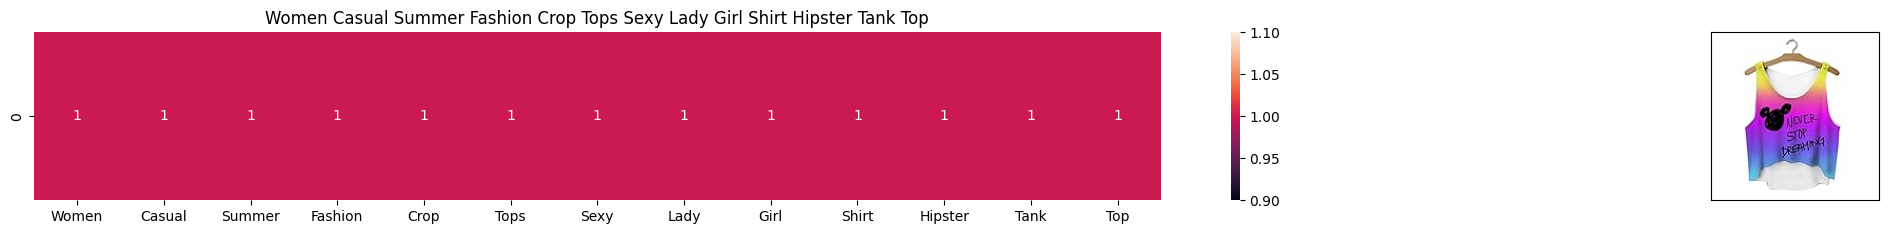

ASIN : B010V3AYSS
Brand: Doxi Supermall
Title: Women Casual Summer Fashion Crop Tops Sexy Lady Girl Shirt Hipster Tank Top
Euclidean similarity with the query image : 1.0


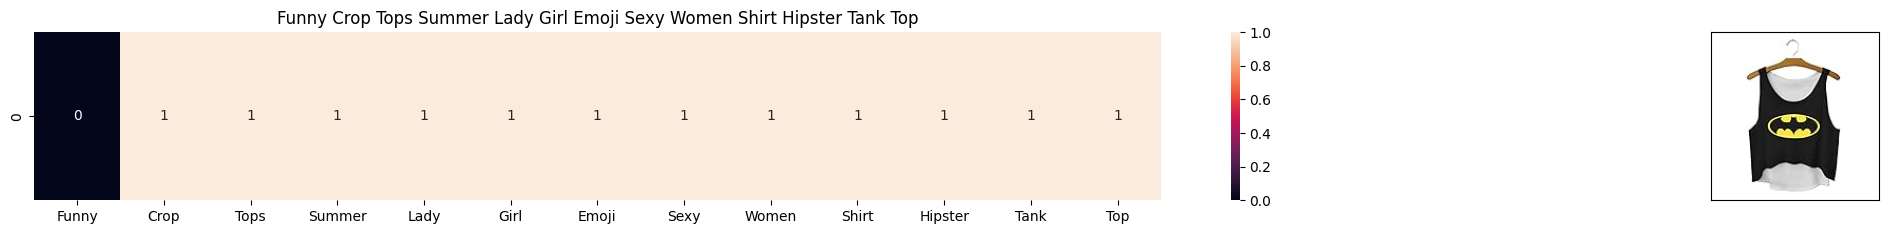

ASIN : B010V3C116
Brand: Doxi Supermall
Title: Funny Crop Tops Summer Lady Girl Emoji Sexy Women Shirt Hipster Tank Top
Euclidean similarity with the query image : 1.7320508075688772


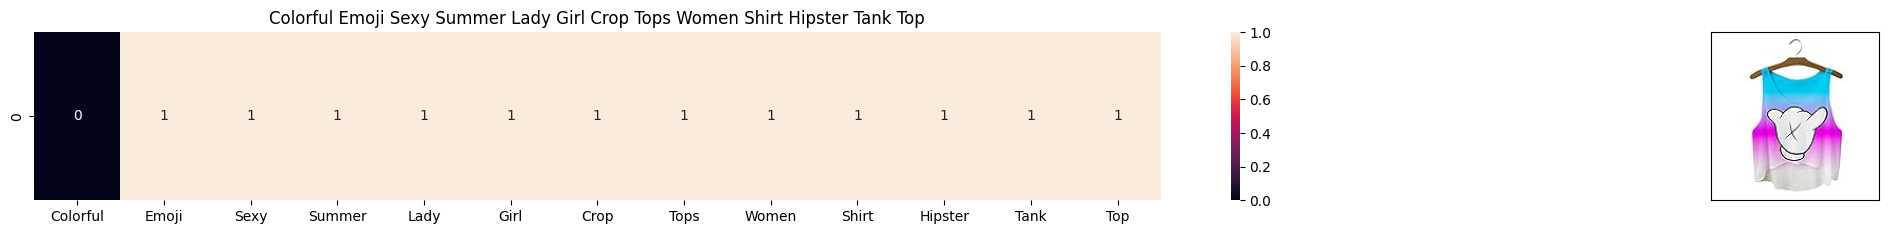

ASIN : B010V3BQZS
Brand: Doxi Supermall
Title: Colorful Emoji Sexy Summer Lady Girl Crop Tops Women Shirt Hipster Tank Top
Euclidean similarity with the query image : 1.7320508075688772


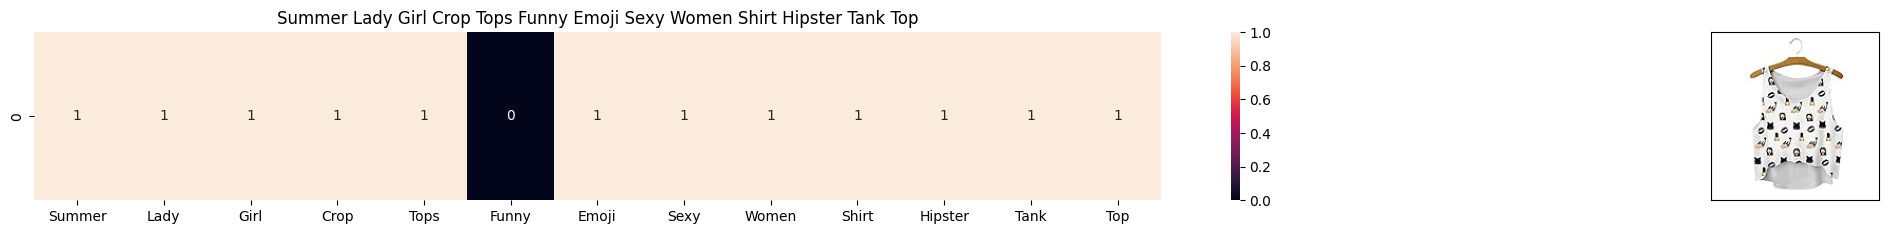

ASIN : B010V3BVMQ
Brand: Doxi Supermall
Title: Summer Lady Girl Crop Tops Funny Emoji Sexy Women Shirt Hipster Tank Top
Euclidean similarity with the query image : 1.7320508075688772


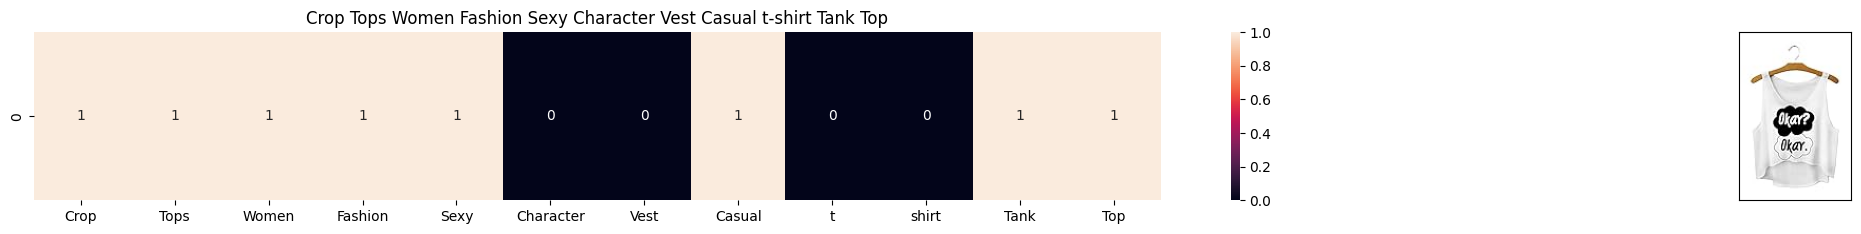

ASIN : B0107UEPVM
Brand: Mang GO
Title: Crop Tops Women Fashion Sexy Character Vest Casual t-shirt Tank Top
Euclidean similarity with the query image : 2.6457513110645907


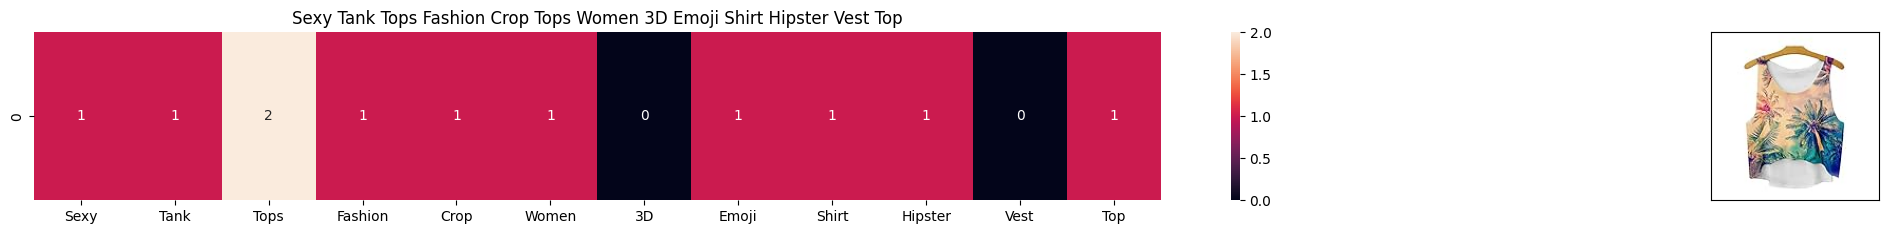

ASIN : B010V3DB9C
Brand: Doxi Supermall
Title: Sexy Tank Tops Fashion Crop Tops Women 3D Emoji Shirt Hipster Vest Top
Euclidean similarity with the query image : 2.6457513110645907


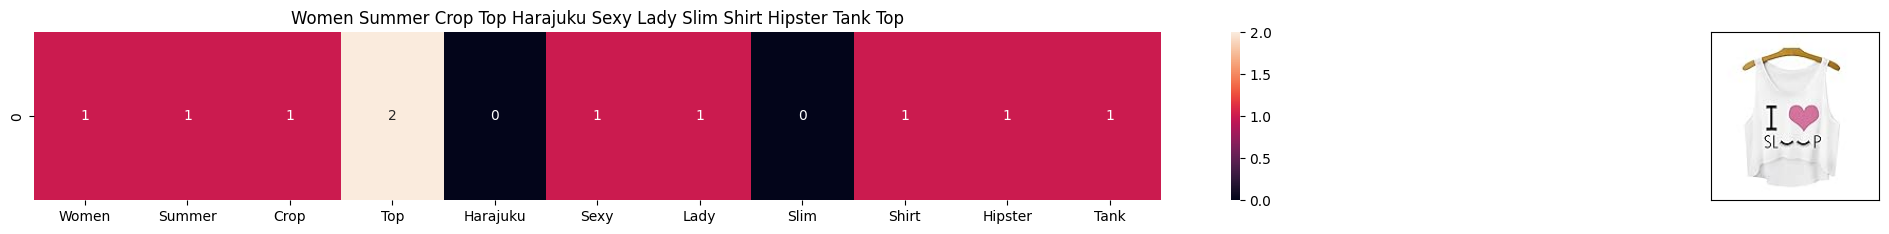

ASIN : B010V3EDEE
Brand: Doxi Supermall
Title: Women Summer Crop Top Harajuku Sexy Lady Slim Shirt Hipster Tank Top
Euclidean similarity with the query image : 2.8284271247461903


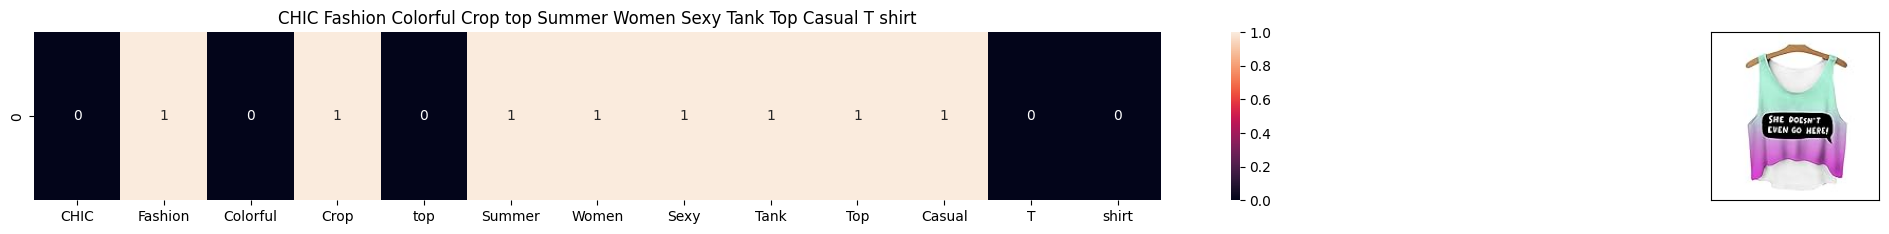

ASIN : B011RCJ6UE
Brand: Chiclook Cool
Title: CHIC Fashion Colorful Crop top Summer Women Sexy Tank Top Casual T shirt
Euclidean similarity with the query image : 2.8284271247461903


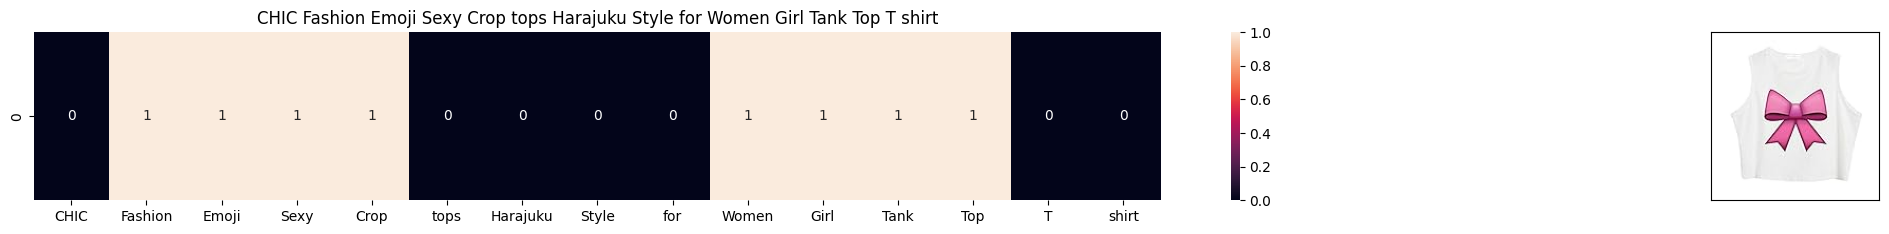

ASIN : B011RCJPR8
Brand: Chiclook Cool
Title: CHIC Fashion Emoji Sexy Crop tops Harajuku Style for Women Girl Tank Top T shirt
Euclidean similarity with the query image : 2.8284271247461903


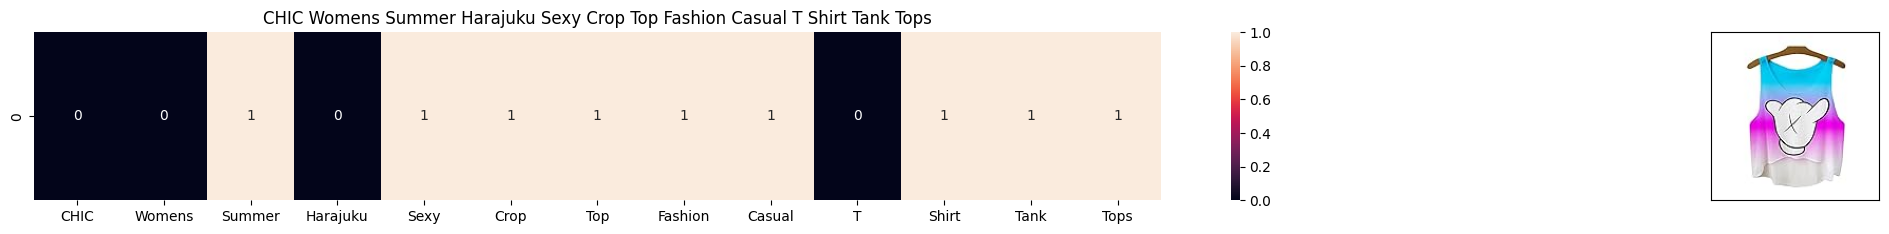

ASIN : B011RCJEMO
Brand: Chiclook Cool
Title: CHIC Womens Summer Harajuku Sexy Crop Top Fashion Casual T Shirt Tank Tops
Euclidean similarity with the query image : 2.8284271247461903


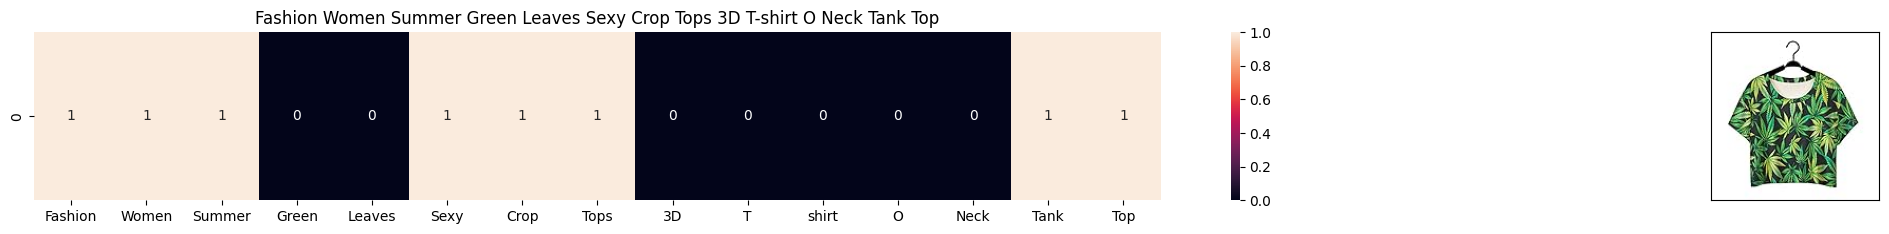

ASIN : B0124E7AW0
Brand: Doxi Supermall
Title: Fashion Women Summer Green Leaves Sexy Crop Tops 3D T-shirt O Neck Tank Top
Euclidean similarity with the query image : 3.0


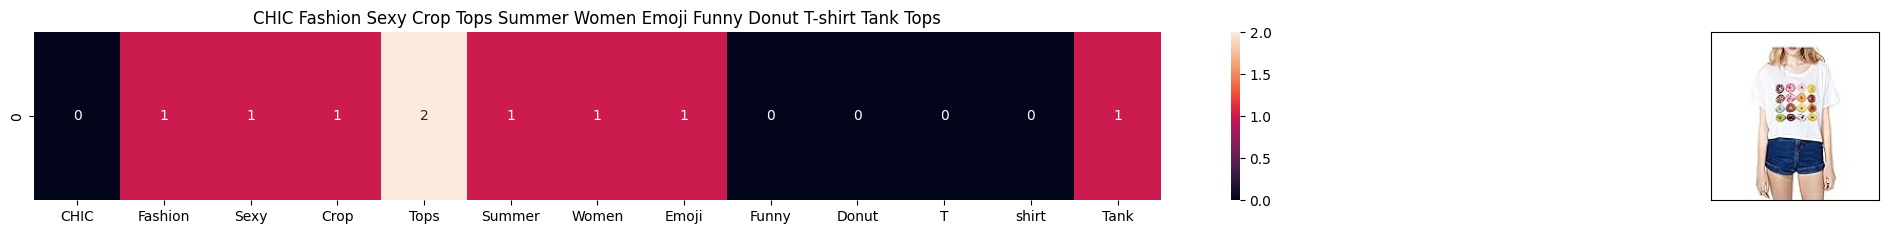

ASIN : B011UEUTQE
Brand: Chiclook Cool
Title: CHIC Fashion Sexy Crop Tops Summer Women Emoji Funny Donut T-shirt Tank Tops
Euclidean similarity with the query image : 3.0


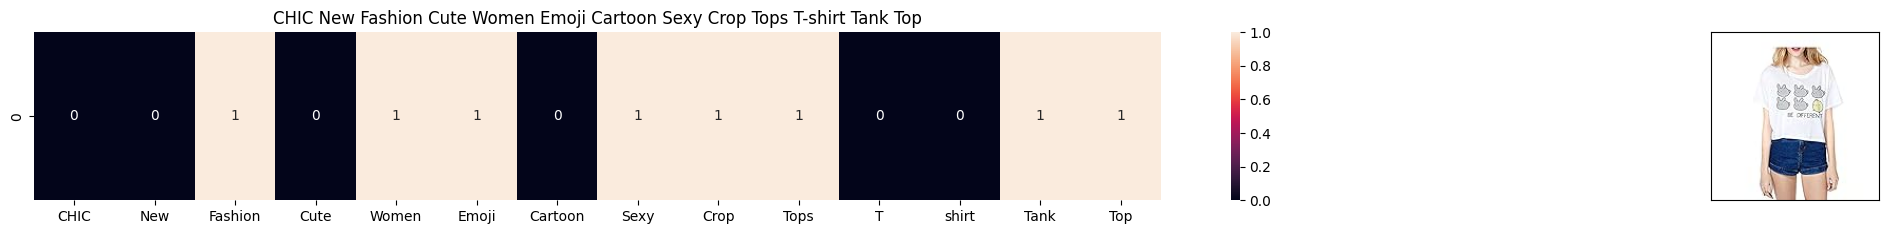

ASIN : B011UEWSFE
Brand: Chiclook Cool
Title: CHIC New Fashion Cute Women Emoji Cartoon Sexy Crop Tops T-shirt Tank Top
Euclidean similarity with the query image : 3.0


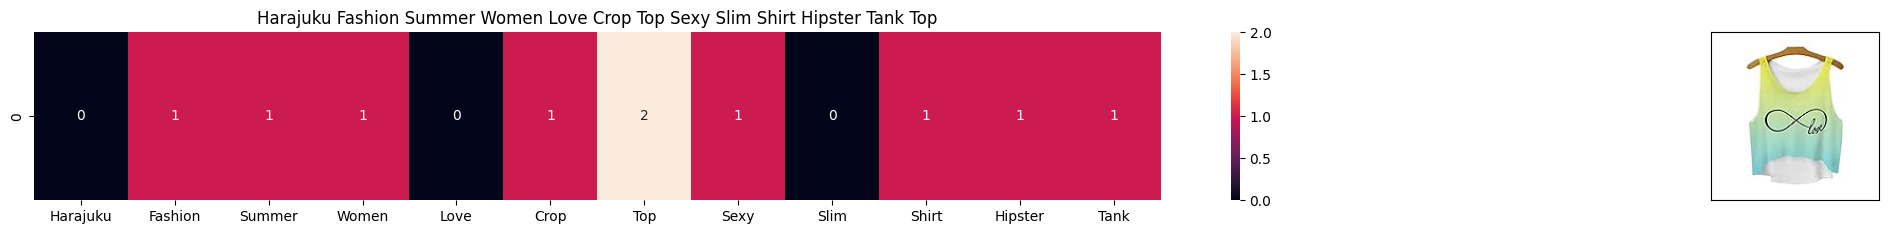

ASIN : B010V35OBU
Brand: Doxi Supermall
Title: Harajuku Fashion Summer Women Love Crop Top Sexy Slim Shirt Hipster Tank Top
Euclidean similarity with the query image : 3.0


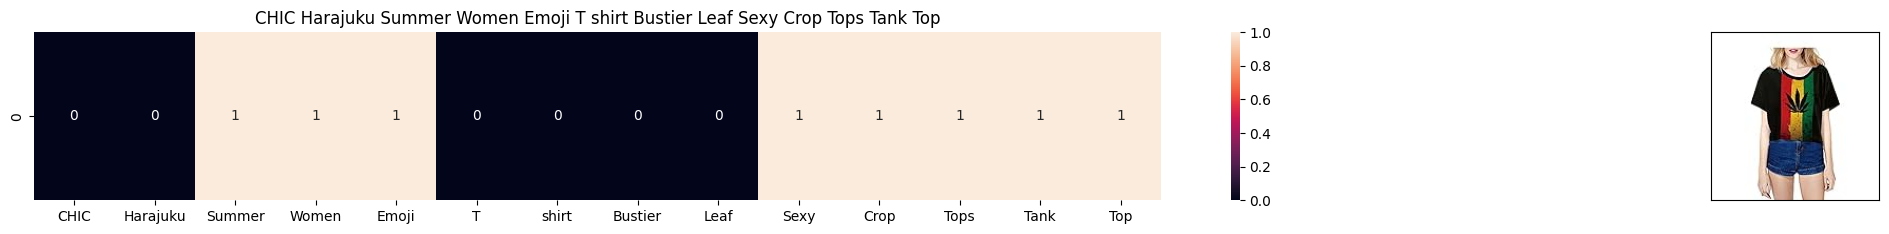

ASIN : B011UEXGH8
Brand: Chiclook Cool
Title: CHIC Harajuku Summer Women Emoji T shirt Bustier Leaf Sexy Crop Tops Tank Top
Euclidean similarity with the query image : 3.0


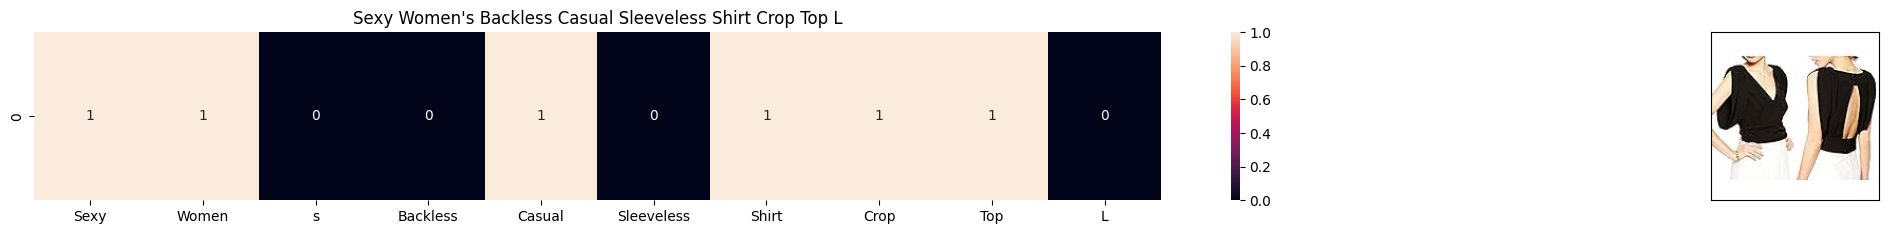

ASIN : B00PBXP3QW
Brand: Wotefusi
Title: Sexy Women's Backless Casual Sleeveless Shirt Crop Top L
Euclidean similarity with the query image : 3.1622776601683795


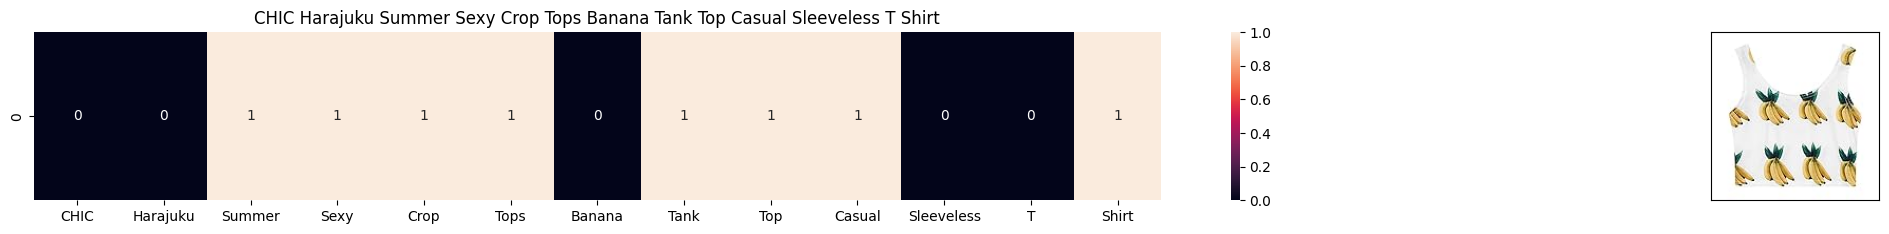

ASIN : B011RCIQBE
Brand: Chiclook Cool
Title: CHIC Harajuku Summer Sexy Crop Tops Banana Tank Top Casual Sleeveless T Shirt
Euclidean similarity with the query image : 3.1622776601683795


In [51]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 20) # change the index if you want to.
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

#try 12566
#try 931

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_title_vectorizer = TfidfVectorizer(min_df=1)  # ✅ Fix: Use 1 instead of 0
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

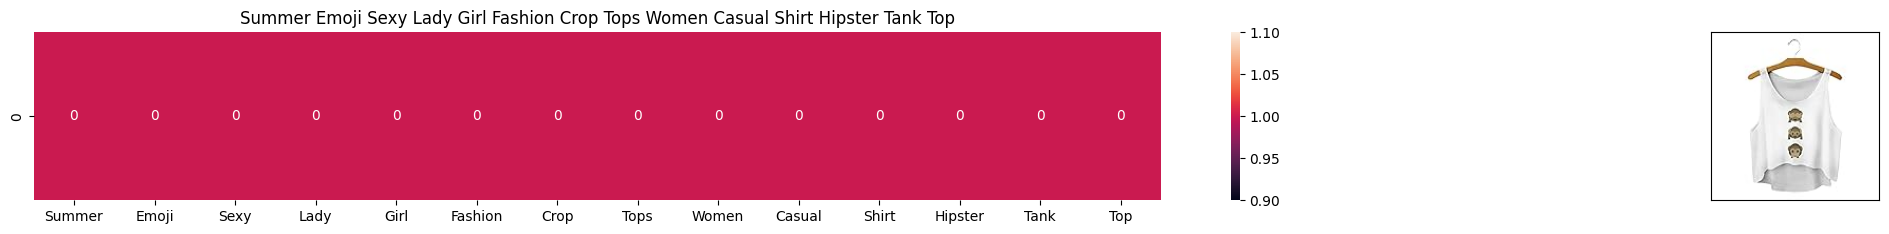

ASIN : B010V3BDII
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.0


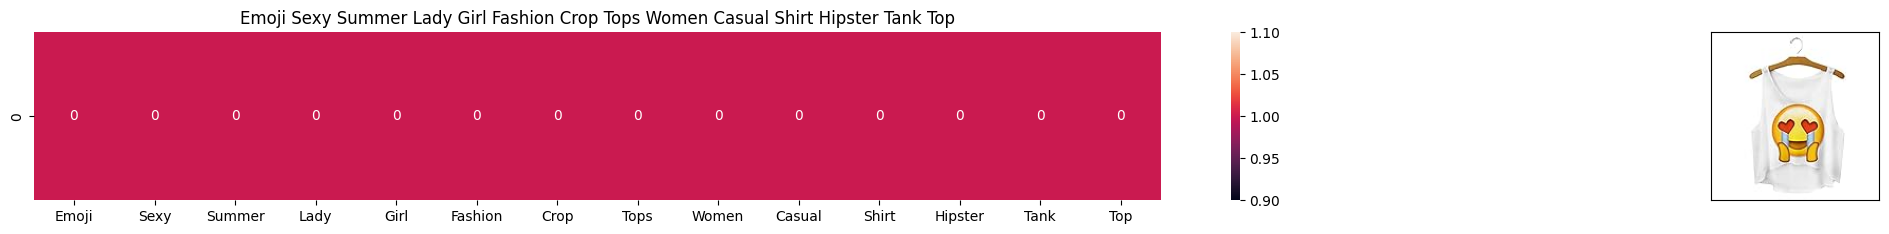

ASIN : B010V3BLWQ
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.0


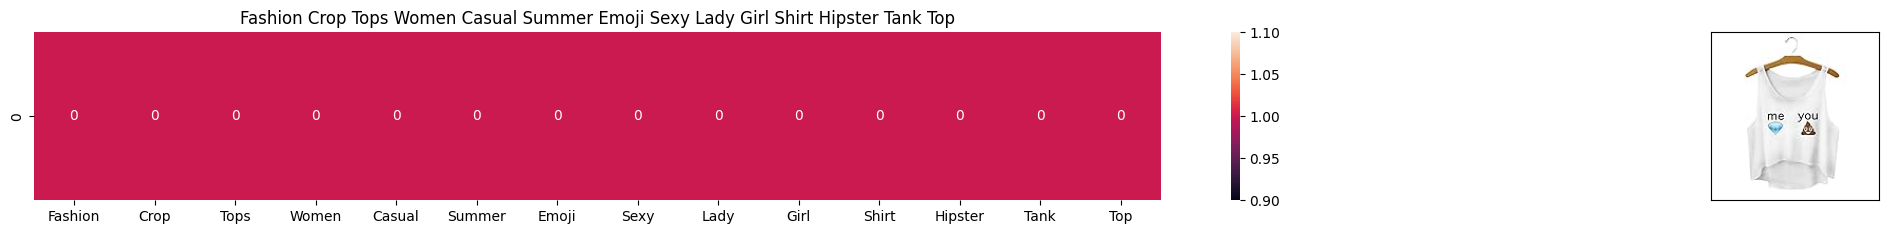

ASIN : B010V3B44G
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.0


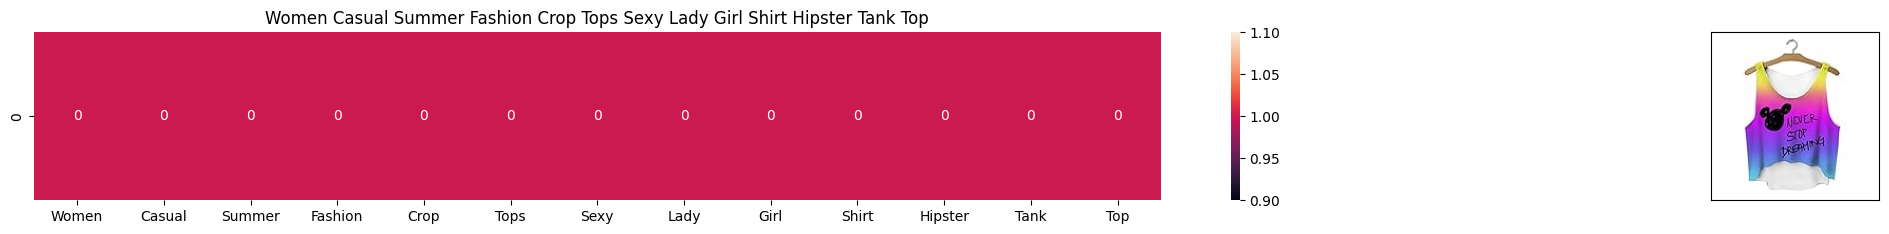

ASIN : B010V3AYSS
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.4113102761704097


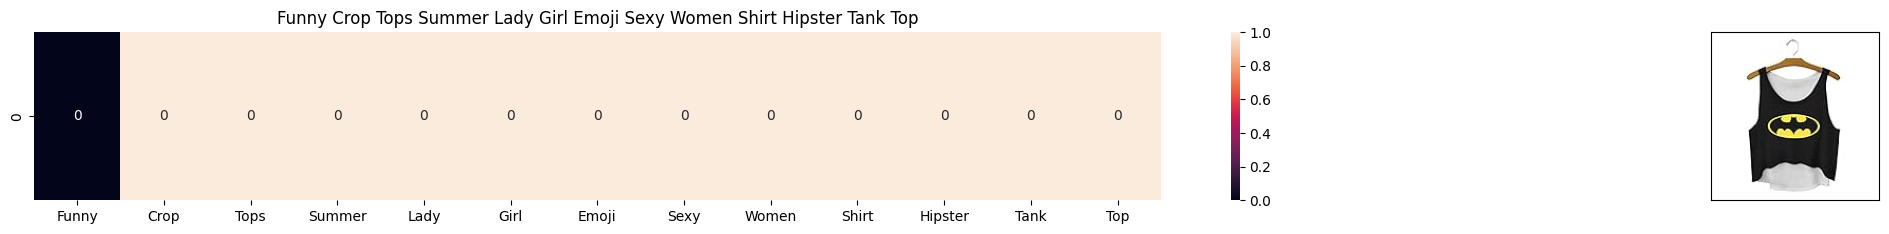

ASIN : B010V3C116
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.5058256149678769


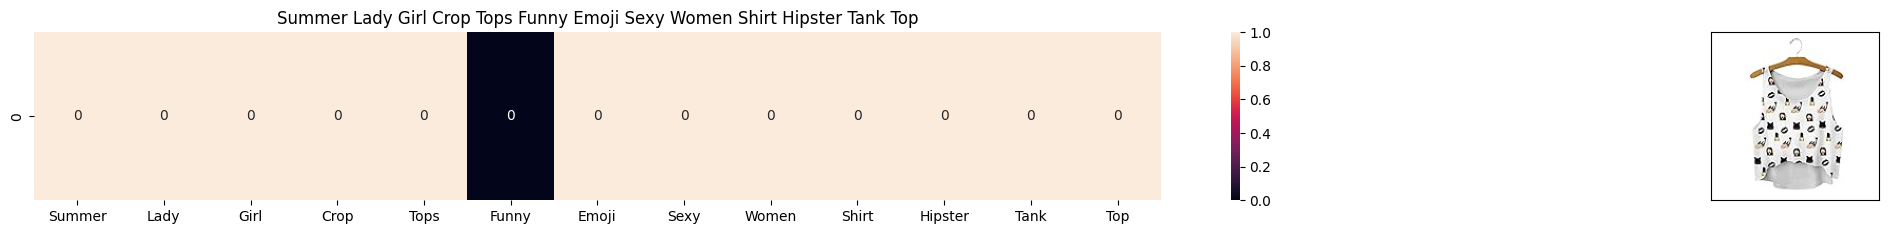

ASIN : B010V3BVMQ
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.5058256149678769


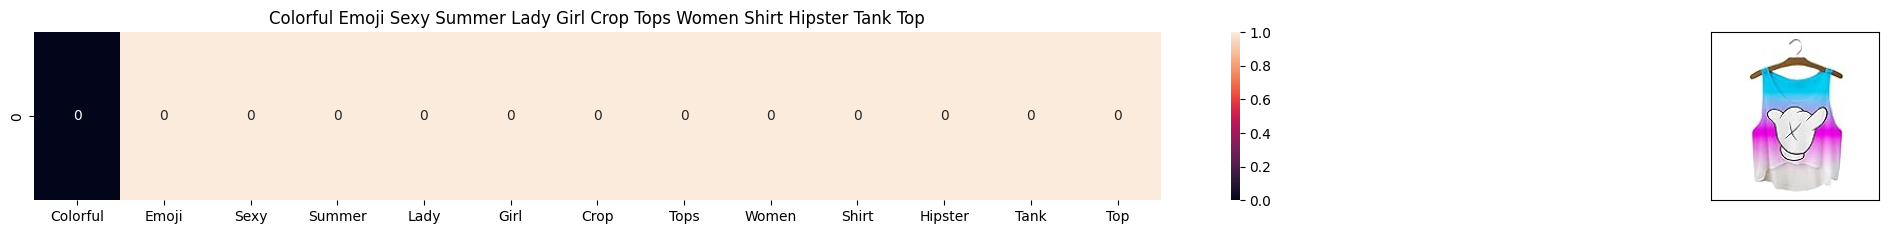

ASIN : B010V3BQZS
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.534910999074809


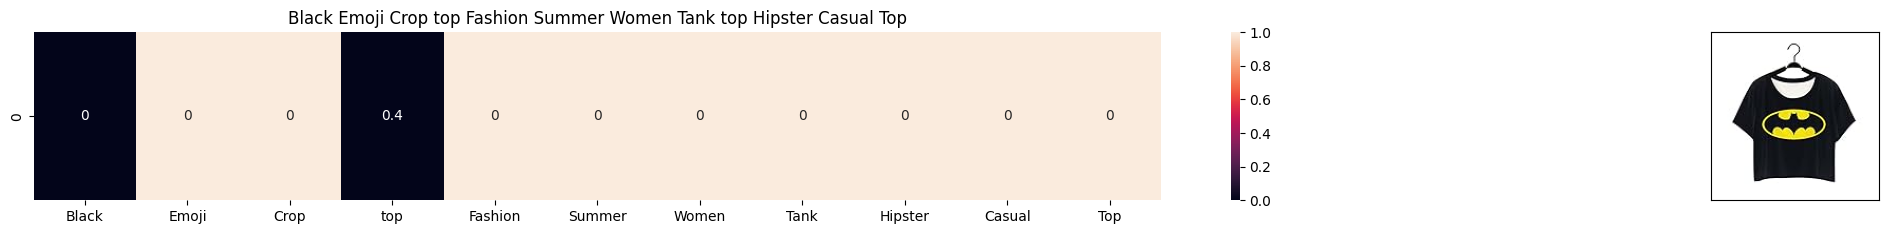

ASIN : B0124E80M4
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.6832693118471956


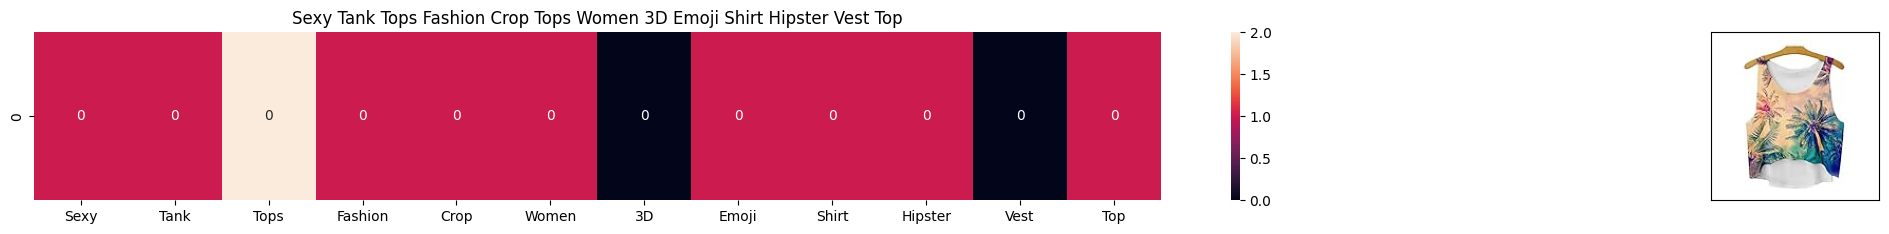

ASIN : B010V3DB9C
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.7833061016905791


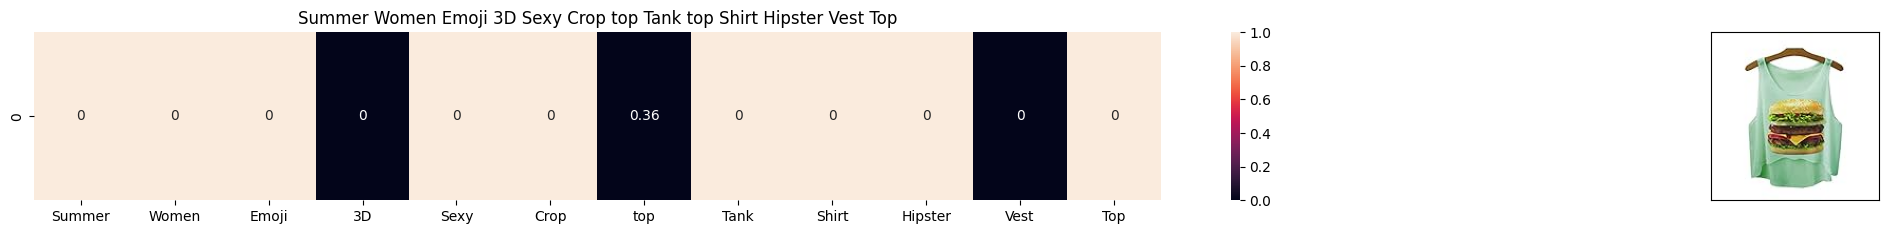

ASIN : B010V3E5EC
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.8238991885671382


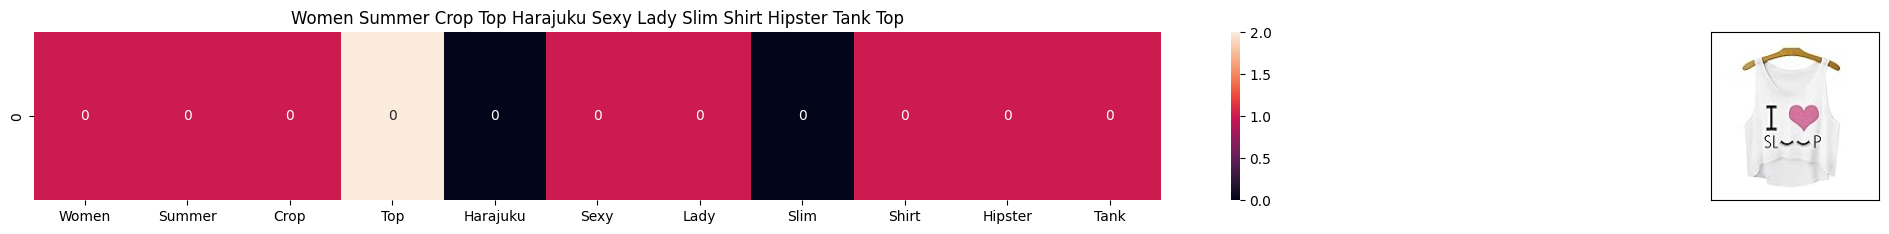

ASIN : B010V3EDEE
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.8618181322866205


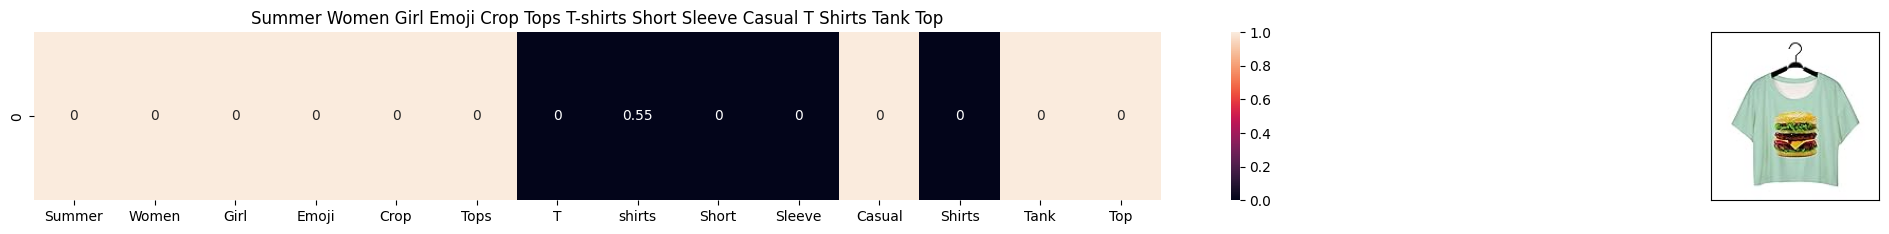

ASIN : B0124ECIU4
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.9040662732103562


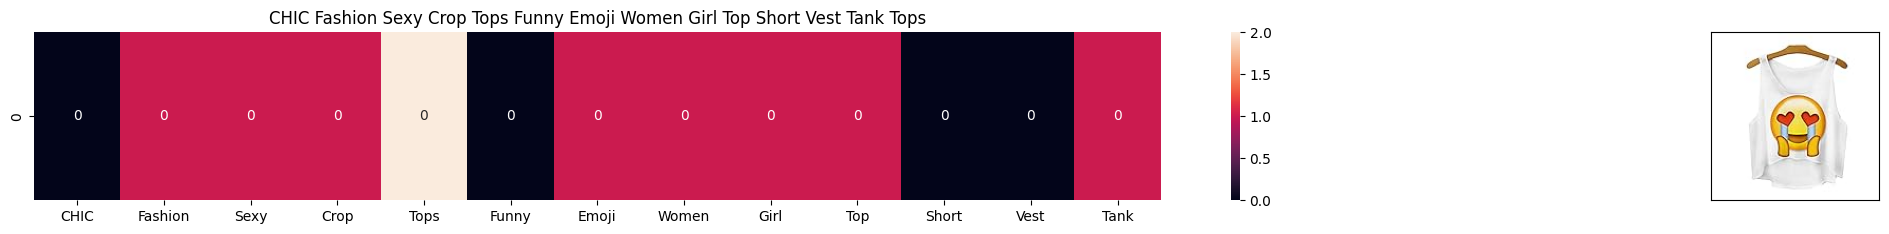

ASIN : B011RCJH58
BRAND : Chiclook Cool
Eucliden distance from the given image : 0.908658500991311


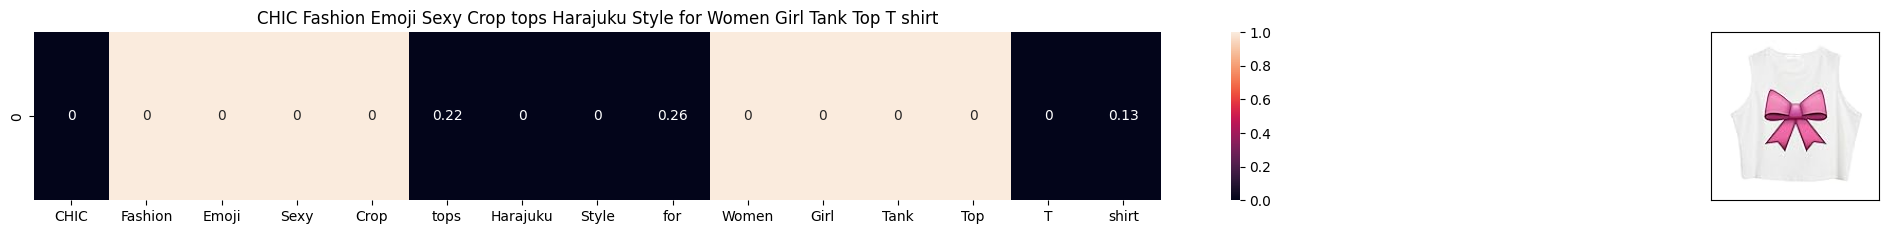

ASIN : B011RCJPR8
BRAND : Chiclook Cool
Eucliden distance from the given image : 0.9195742171591084


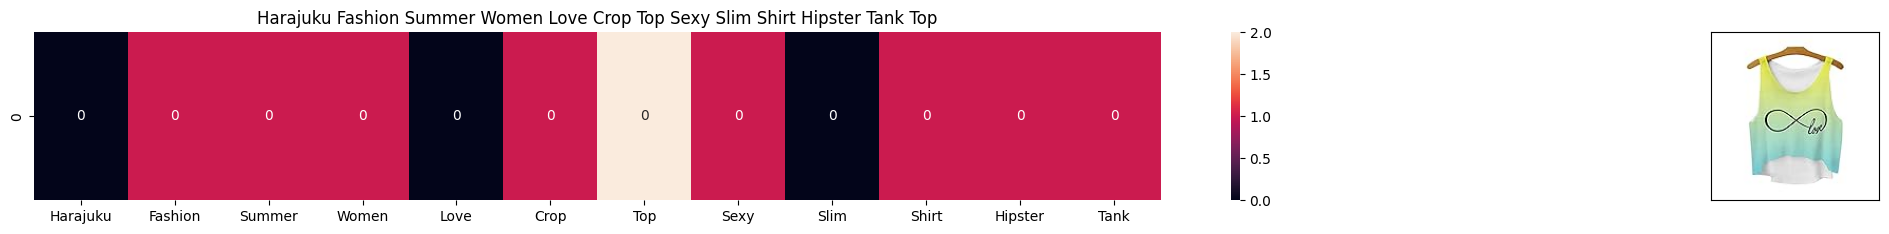

ASIN : B010V35OBU
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.9321770066161585


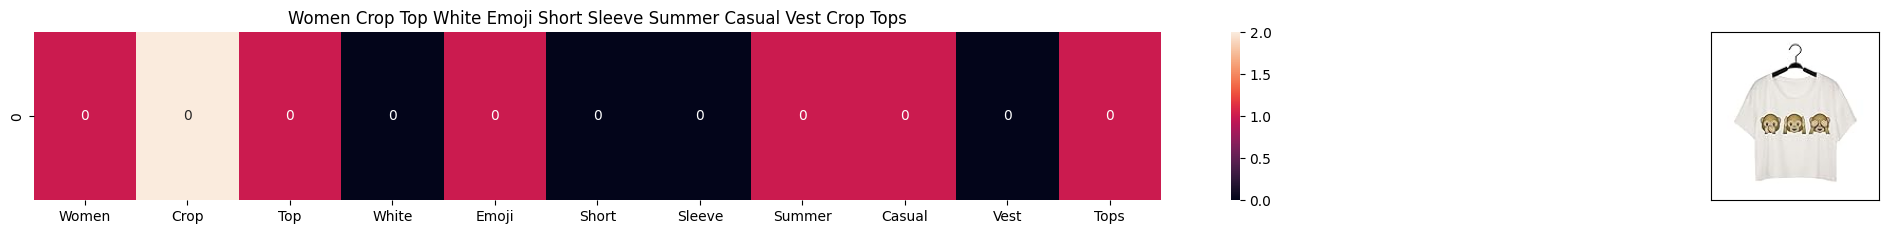

ASIN : B0124E7MHS
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.9401349130099196


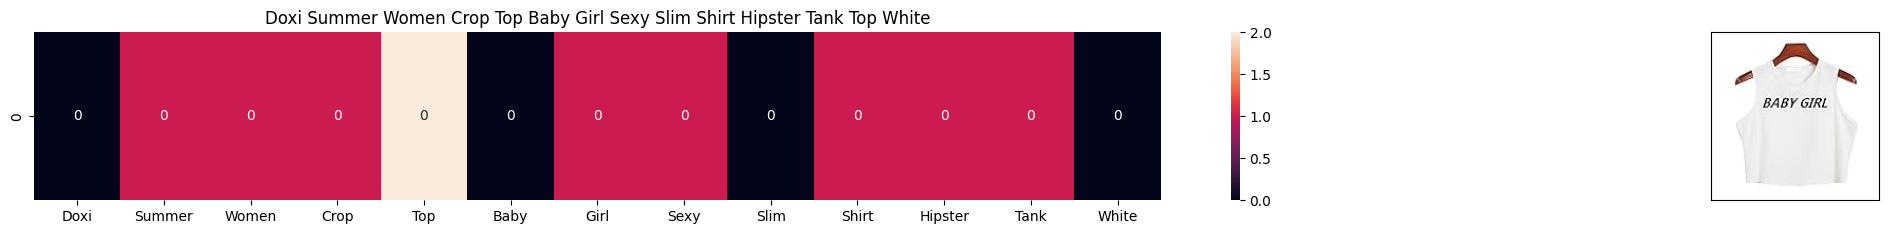

ASIN : B010V3A23U
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.9449850245789151


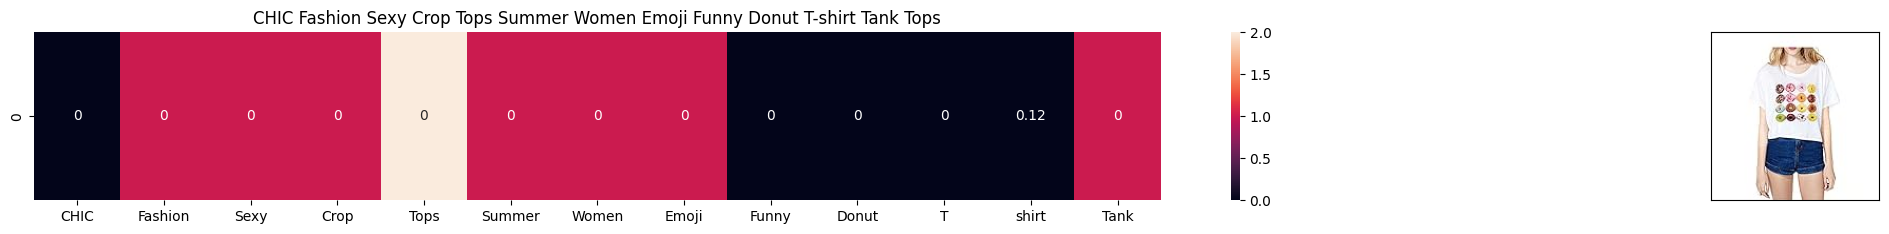

ASIN : B011UEUTQE
BRAND : Chiclook Cool
Eucliden distance from the given image : 0.9494000343986913


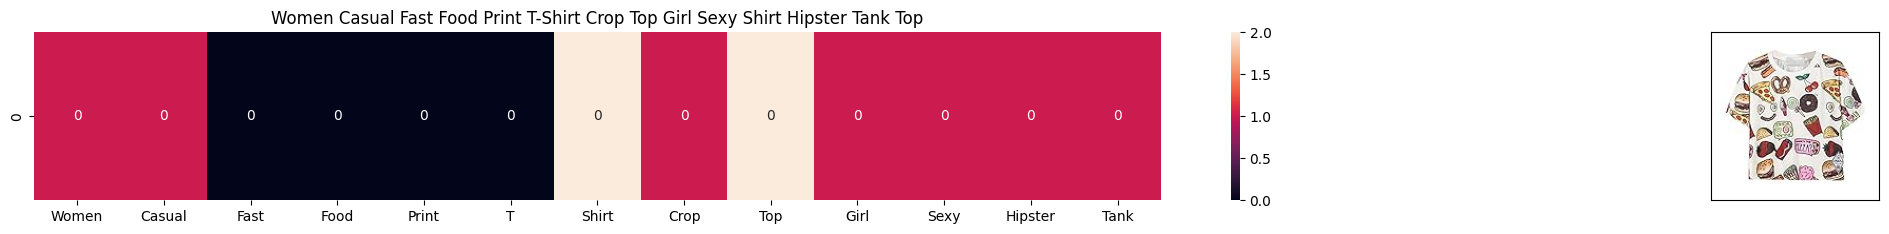

ASIN : B010V3AB5O
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.9784868026332303


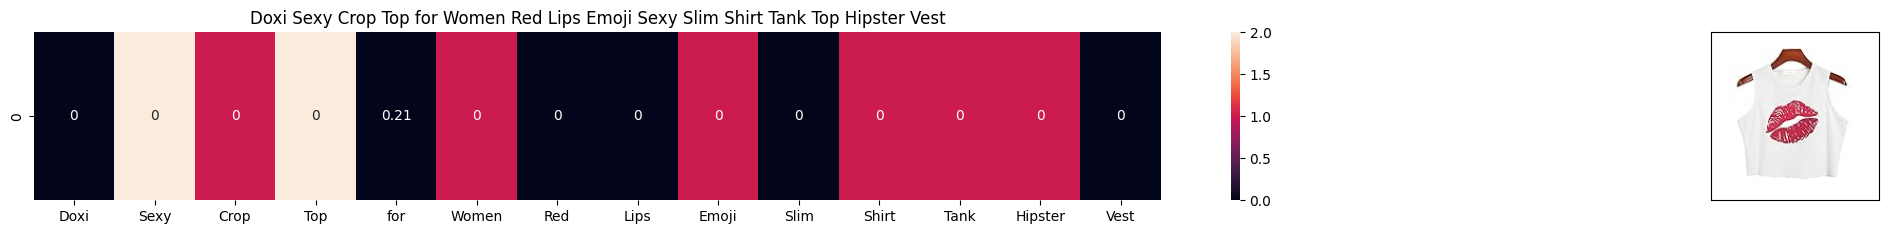

ASIN : B010TKXEHG
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.9794304908974127


In [55]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title